# Lab Course: Distributed Data Analytics Exercise Sheet 9
**Submitted by: Mohit Bansal**

**Student ID: 279314**

### Exercise 1: Apache Spark Basics ( 10 points)

#### Part a) Basic Operations on Resilient Distributed Dataset (RDD) (4 points)

Let’s have two lists of words as follows:

    a = ["spark", "rdd", "python", "context", "create", "class"]

    b = ["operation", "apache", "scala", "lambda","parallel","partition"]

Create two RDD objects of a, b and do the following tasks. Words should be remained in the results of join operations.


In [46]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 26 13:39:13 2018

@author: mundanemohit
"""

# Load libraries
import datetime
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, datediff, to_timestamp, unix_timestamp, to_date
from pyspark.sql.functions import when, col, round
from pyspark.sql.functions import max as max_, min as min_
from pyspark.sql.functions import explode, split
from pyspark.sql.functions import stddev, mean as mean_, count as count_
from pyspark.sql.functions import dense_rank, udf
from pyspark.sql.window import Window

path = '/Users/mundanemohit/Google Drive/My Work/MSc. Data Analytics/3114 Distributed Data Analytics/Excercises/Ex09/'

# Create a spark session
spark = SparkSession \
 .builder \
 .appName("Python Spark - Testing the Waters") \
 .config("spark.some.config.option", "some-value") \
 .getOrCreate()
 
sc = spark.sparkContext

# Define data as a list
a =["spark", "rdd", "python", "context", "create", "class"]
b = ["operation", "apache", "scala", "lambda","parallel","partition"]

# Convert list to RDDs
rddA = sc.parallelize(a)
rddB = sc.parallelize(b)

A1. Perform **rightOuterJoin** and **fullOuterJoin** operations between a and b. Briefly explain your solution. (1 point)

In [5]:
# Add key pair for joining
distA = rddA.map(lambda word:(word,'a'))
distB = rddB.map(lambda word:(word,'b'))

# RightOuterJoin
rjoin = distA.rightOuterJoin(distB).collect()
print("RIGHT OUTER JOIN: \n", rjoin, "\n")

# FullOuterJoin
fjoin = distA.fullOuterJoin(distB).collect()
print("FULL OUTER JOIN: \n",fjoin)

RIGHT OUTER JOIN: 
 [('scala', (None, 'b')), ('parallel', (None, 'b')), ('operation', (None, 'b')), ('apache', (None, 'b')), ('partition', (None, 'b')), ('lambda', (None, 'b'))] 

FULL OUTER JOIN: 
 [('python', ('a', None)), ('spark', ('a', None)), ('context', ('a', None)), ('create', ('a', None)), ('scala', (None, 'b')), ('parallel', (None, 'b')), ('operation', (None, 'b')), ('apache', (None, 'b')), ('partition', (None, 'b')), ('lambda', (None, 'b')), ('class', ('a', None)), ('rdd', ('a', None))]


A2. Using **map** and **reduce** functions to count how many times the character "s" appears in all a and b. (1 point)

In [6]:
# Count S in A & B
s_countA = rddA.union(rddB) \
                .flatMap(lambda word:list(word)) \
                .map(lambda x:x.count('s')) \
                .reduce(lambda x,y:x+y)
print("No. of 's' in the list: ", s_countA)

No. of 's' in the list:  4


A.3 Using **aggregate** function to count how many times the character "s" appears in all a and b. (1 point)

In [7]:
# Aggregate S in A & B
s_countA = rddA.union(rddB) \
                .flatMap(lambda word:list(word)) \
                .map(lambda x:x.count('s')) \
                .aggregate((0,0), 
                           seqOp = lambda agg, x: (agg[0] + x, agg[1] + 1),
                           combOp = lambda agg, x: (agg[0] + x[0], agg[1] + x[1]))
print("(Count of 's', Total letters) = ", s_countA)

(Count of 's', Total letters) =  (4, 75)


#### Part b) Basic Operations on DataFrames (6 points)

Use dataset students.json (download from learnweb) for this exercise.

In [8]:
# DATAFRAMES
df = spark.read.json(path + 'students.json')

df.printSchema()    # Show structure of DataFrame
df.show()          # Show first few datapoints

root
 |-- course: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- points: long (nullable = true)
 |-- s_id: long (nullable = true)

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978

First creating DataFrames from the dataset and do several tasks as follows:

**B1. Replace the null value(s) in column points by the mean of all points. (0.5 point)**

In [9]:
# Replace null value in points with mean
df = df.fillna(df.agg({'points': 'mean'}).collect()[0][0], 'points')
df.show()

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|     null|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     June 12, 1975|     Holly| 

**B2. Replace the null value(s) in column dob and column last name by "unknown" and "--" respectively. (0.5 point)**

In [10]:
# Replace null value in dob with 'unknown'
df = df.fillna('unknown', 'dob')

# Replace null value in last_name with '--'
df = df.fillna('--', 'last_name')
df.show()

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|       --|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     June 12, 1975|     Holly| 

**B3. In the dob column, there exist several formats of dates, e.g. October 14, 1983 and 26 December 1989. Let’s convert all the dates into DD-MM-YYYY format where DD, MM and YYYY are two digits for day, two digits for months and four digits for year respectively. (2 points)**

In [11]:
# Create new column by transforming dates
xdf = df.select('*', to_timestamp(df.dob, 'MMMMM dd, yyyy').alias('date'))
#xdf.show()
xdf = xdf.withColumn('date', when(col('date').isNull(), to_timestamp(df.dob, 'dd MMMMM yyyy')).otherwise(col('date')))
#xdf.show()
# xdf = xdf.withColumn('date', when(col('date').isNull(), '1000-01-01 00:00:00').otherwise(col('date')))
# xdf.show()
xdf = xdf.withColumn('dob', unix_timestamp(col("date"), 'yyyy-MM-dd HH:mm:ss').cast("timestamp"))
#xdf.show()
#xdf.printSchema()
xdf = xdf.drop('date')
xdf = xdf.withColumn('dob', to_date('dob', 'dd-MM-yyyy'))
xdf.show()
xdf.printSchema()

+------------------+----------+----------+---------+------+----+
|            course|       dob|first_name|last_name|points|s_id|
+------------------+----------+----------+---------+------+----+
|Humanities and Art|1983-10-14|      Alan|      Joe|    10|   1|
|  Computer Science|1980-09-26|    Martin|  Genberg|    17|   2|
|    Graphic Design|1982-06-12|     Athur|   Watson|    16|   3|
|    Graphic Design|1987-04-05|  Anabelle|  Sanberg|    12|   4|
|        Psychology|1978-11-01|      Kira| Schommer|    11|   5|
|          Business|1981-02-17| Christian|   Kiriam|    10|   6|
|  Machine Learning|1984-01-01|   Barbara|  Ballard|    14|   7|
|     Deep Learning|1978-01-13|      John|       --|    10|   8|
|  Machine Learning|1989-12-26|    Marcus|   Carson|    15|   9|
|           Physics|1987-12-30|     Marta|   Brooks|    11|  10|
|    Data Analytics|1975-06-12|     Holly| Schwartz|    12|  11|
|  Computer Science|1985-07-02|     April|    Black|    11|  12|
|  Computer Science|1980-

**B4. Insert a new column age and calculate the current age of all students. (1 point)**

In [12]:
# Add age column
xdf = xdf.select('*', round(datediff(lit(datetime.date.today()), col('dob'))/365.25,0).alias('age'))
xdf.show()

+------------------+----------+----------+---------+------+----+----+
|            course|       dob|first_name|last_name|points|s_id| age|
+------------------+----------+----------+---------+------+----+----+
|Humanities and Art|1983-10-14|      Alan|      Joe|    10|   1|35.0|
|  Computer Science|1980-09-26|    Martin|  Genberg|    17|   2|38.0|
|    Graphic Design|1982-06-12|     Athur|   Watson|    16|   3|36.0|
|    Graphic Design|1987-04-05|  Anabelle|  Sanberg|    12|   4|31.0|
|        Psychology|1978-11-01|      Kira| Schommer|    11|   5|40.0|
|          Business|1981-02-17| Christian|   Kiriam|    10|   6|37.0|
|  Machine Learning|1984-01-01|   Barbara|  Ballard|    14|   7|35.0|
|     Deep Learning|1978-01-13|      John|       --|    10|   8|40.0|
|  Machine Learning|1989-12-26|    Marcus|   Carson|    15|   9|29.0|
|           Physics|1987-12-30|     Marta|   Brooks|    11|  10|31.0|
|    Data Analytics|1975-06-12|     Holly| Schwartz|    12|  11|43.0|
|  Computer Science|

**B5. Let’s consider granting some points for good performed students in the class. For each student, if his point is larger than 1 standard deviation of all points, then we update his current point to 20, which is the maximum. See Annex 1 for a tutorial on how to calculate standard deviation. (2 points)**

**B6. Create a histogram on the new points created in the task 5. (1 point)**

+------------------+----------+----------+---------+------+----+----+
|            course|       dob|first_name|last_name|points|s_id| age|
+------------------+----------+----------+---------+------+----+----+
|Humanities and Art|1983-10-14|      Alan|      Joe|    10|   1|35.0|
|  Computer Science|1980-09-26|    Martin|  Genberg|    20|   2|38.0|
|    Graphic Design|1982-06-12|     Athur|   Watson|    20|   3|36.0|
|    Graphic Design|1987-04-05|  Anabelle|  Sanberg|    12|   4|31.0|
|        Psychology|1978-11-01|      Kira| Schommer|    11|   5|40.0|
|          Business|1981-02-17| Christian|   Kiriam|    10|   6|37.0|
|  Machine Learning|1984-01-01|   Barbara|  Ballard|    14|   7|35.0|
|     Deep Learning|1978-01-13|      John|       --|    10|   8|40.0|
|  Machine Learning|1989-12-26|    Marcus|   Carson|    20|   9|29.0|
|           Physics|1987-12-30|     Marta|   Brooks|    11|  10|31.0|
|    Data Analytics|1975-06-12|     Holly| Schwartz|    12|  11|43.0|
|  Computer Science|

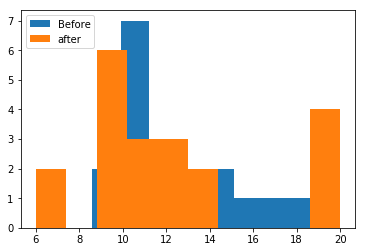

In [13]:
# Update points if they are greater than given benchmark
plt.hist(xdf.select('points').rdd.map(lambda row : row.points).collect(), label = 'Before')   # Before update
# Calculate benchmark
benchmark = xdf.agg({'points': 'mean'}).collect()[0][0] + xdf.agg({'points': 'stddev'}).collect()[0][0]
# Update
xdf = xdf.withColumn('points', when(col('points') > benchmark, 20).otherwise(col('points')))
xdf.show()
# Plot points
plt.hist(xdf.select('points').rdd.map(lambda row : row.points).collect(), label = 'after')  # After update
plt.legend(loc = 'upper left')
plt.show()

### Exercise 2: Manipulating Recommender Dataset with Apache Spark (10 points)

A tagging session for a user can be defined as the duration in which he/she generated tagging activities. Typically, an inactive duration of 30 mins is considered as a termination of the tagging session. 

**1. Your task is to separate out tagging sessions for each user.**

#### Solution:

The task is broken down into following steps:

* Read Data
* Remove junk columns
* Rename columns
* Convert timestamp column to correct format
* Remove any duplicate entries

In [14]:
path = '/Users/mundanemohit/Google Drive/My Work/MSc. Data Analytics/3114 Distributed Data Analytics/Excercises/Ex09/'
file = '/ml-10M100K/tags.dat'

# Read movie data into python
tagDF = spark.read.csv(path+file, sep=':')

# Remove junk columns
tagDF = tagDF.drop('_c1', '_c3', '_c5')

# Rename columns
tagDF = tagDF.selectExpr('_c0 as UserID', '_c2 as MovieID', '_c4 as Tag', '_c6 as Timestamp')

# Modify timestamp column
tagDF = tagDF.withColumn("Timestamp", col('Timestamp').cast("double").cast("timestamp"))  

# Remove duplicate records
tagDF = tagDF.distinct()

tagDF.show(10)
tagDF.printSchema()
tagDF.count()

+------+-------+---------------+-------------------+
|UserID|MovieID|            Tag|          Timestamp|
+------+-------+---------------+-------------------+
|   146|   1028|          magic|2008-03-23 06:54:34|
|   146|   1059|based on a play|2008-03-29 10:19:24|
|   146|   2927|    Noel Coward|2008-11-15 11:32:08|
|   146|   3335|imdb bottom 100|2007-11-21 04:56:51|
|   146|   3653|    New Zealand|2008-12-05 05:55:54|
|   146|   4339|         trains|2007-11-02 01:08:12|
|   146|   5045|imdb bottom 100|2007-11-21 05:08:48|
|   146|   6483|imdb bottom 100|2007-11-21 04:41:56|
|   146|   6672|     journalism|2007-12-07 04:49:02|
|   146|  48738|         Africa|2007-12-14 11:43:16|
+------+-------+---------------+-------------------+
only showing top 10 rows

root
 |-- UserID: string (nullable = true)
 |-- MovieID: string (nullable = true)
 |-- Tag: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)



95373

Further next steps are as follows:

* Identify order of tagging for each user and mark as 'Rank'
* Map next item on list to the current one to calculate time difference
* Use time difference to identify whether a tag belongs to a session or not
* Flag all tags which belong to a session

In [15]:
# Find rank of tags
w =  Window.partitionBy(tagDF['UserID']).orderBy(tagDF['TimeStamp'].asc(), tagDF['MovieID'].asc(), tagDF['tag'].asc())
tagDF = tagDF.withColumn("Rank", dense_rank().over(w))

# Get next tagging time
tagDF.createOrReplaceTempView("tags")
tagDF = spark.sql("SELECT a.*, b.Timestamp as nextag_time                              \
                   FROM tags a                                                         \
                   left join tags b                                                    \
                          on a.UserID = b.UserID                                       \
                         and a.Rank = b.Rank - 1")

# Get time difference in consecutive tags
tagDF = tagDF.withColumn('time_diff', unix_timestamp('nextag_time') - unix_timestamp('Timestamp'))

# flag if tag is part of a session
tagDF = tagDF.withColumn("flag", when(col('time_diff') < 1800, 1).otherwise(0))
tagDF.show(10)

+------+-------+--------------+-------------------+----+-------------------+---------+----+
|UserID|MovieID|           Tag|          Timestamp|Rank|        nextag_time|time_diff|flag|
+------+-------+--------------+-------------------+----+-------------------+---------+----+
| 11563|  37830| final fantasy|2007-10-15 14:58:42|   1|               null|     null|   0|
|  1436|    838|       cottage|2007-09-02 18:44:43|   1|2007-09-02 18:45:02|       19|   1|
|  1436|   1953|action classic|2007-09-02 18:45:02|   2|2007-09-02 18:46:17|       75|   1|
|  1436|   1231|       awesome|2007-09-02 18:46:17|   3|2007-09-02 18:46:20|        3|   1|
|  1436|    247| coming of age|2007-09-02 18:46:20|   4|2007-09-02 18:46:34|       14|   1|
|  1436|   1994|           80s|2007-09-02 18:46:34|   5|2007-09-02 18:47:04|       30|   1|
|  1436|   1179|     new  nior|2007-09-02 18:47:04|   6|2007-09-02 18:47:26|       22|   1|
|  1436|  32587|    comic book|2007-09-02 18:47:26|   7|2007-09-02 18:47:48|    

Now we need to create a **user-defined function** to identify each unique tagging session for a user.

* Map flag of previous tag to current tag
* If current tag belongs to previous session, we assign the same session id
* If not, we increment the session id by 1

In [16]:
# Map previous flag
tagDF.createOrReplaceTempView("tags")
a = tagDF.alias('a')
b = tagDF.alias('b')

tagDF = spark.sql("SELECT a.*, b.flag as prflag        \
                   FROM tags a                         \
                   left join tags b                    \
                          on a.UserID = b.UserID       \
                         and a.Rank = b.Rank + 1       \
                   order by a.userid, a.rank")

In [17]:
#global variable
count = 1
# For tagging
def tagSession(flag, prflag):
    global count
    # First entry  --> return 1
    if prflag is None:
        count = 1
        return count
    # Same session -----> return same session ID
    if prflag == 1:
        return count
    # New session  ----> increment session id
    elif prflag == 0:
        count = count + 1
        return count
    # Unknown possibility
    else:   
        return -1

# Create UDF
sessUDF = udf(tagSession)

# Sort dataset
tagDF = tagDF.sort("UserID", "Rank")

# Create session IDs
tagDF = tagDF.withColumn('SessionID', sessUDF("flag", "prflag"))

# Drop additional columns
tagDF = tagDF.drop('nextag_time', 'flag', 'prflag', 'time_diff')

tagDF.show(50)

+------+-------+----------------+-------------------+----+---------+
|UserID|MovieID|             Tag|          Timestamp|Rank|SessionID|
+------+-------+----------------+-------------------+----+---------+
|  1000|    277|children's story|2007-08-31 06:05:11|   1|        1|
|  1000|   1994|    sci-fi. dark|2007-08-31 06:05:36|   2|        1|
|  1000|   5377|         romance|2007-08-31 06:05:50|   3|        1|
|  1000|   7147|    family bonds|2007-08-31 06:06:01|   4|        1|
|  1000|    362|animated classic|2007-08-31 06:06:11|   5|        1|
|  1000|    276|          family|2007-08-31 06:07:15|   6|        1|
| 10003|  42013|        Passable|2006-06-16 06:33:55|   1|        1|
| 10003|  51662|  FIOS on demand|2008-04-12 00:35:26|   2|        2|
| 10003|  54997|  FIOS on demand|2008-04-12 00:35:35|   3|        2|
| 10003|  55765|  FIOS on demand|2008-04-12 00:35:42|   4|        2|
| 10003|  55363|  FIOS on demand|2008-04-12 00:37:00|   5|        2|
| 10003|  56152|  FIOS on demand|2

Now we have successfully identified each user session and are ready to start with the other tasks.

**2. Calculate the frequency of tagging for each user session.**

In [18]:
summDF = tagDF.groupby(['UserID', 'SessionID']).count()                         \
              .select('UserID', 'SessionID', col('count').alias('num_tags'))    \
              .sort("UserID", "SessionID").cache()                                      \

summDF.show(10)

+------+---------+--------+
|UserID|SessionID|num_tags|
+------+---------+--------+
|  1000|        1|       6|
| 10003|        1|       1|
| 10003|        2|      18|
| 10003|        3|      38|
| 10020|        1|       2|
| 10025|        1|       1|
| 10032|        1|      39|
| 10032|       10|       1|
| 10032|       11|       1|
| 10032|       12|       1|
+------+---------+--------+
only showing top 10 rows



**3. Find a mean and standard deviation of the tagging frequency of each user.**

In [48]:
userDF =  summDF.groupby('UserID')                                  \
                .agg(mean_('num_tags').alias('avg_tags_per_session')
                    ,count_(lit(1)).alias('num_sessions')      
                    ,stddev('num_tags').alias('std_dev'))           \
                .sort('UserID')                           

userDF.show(10)

+------+--------------------+------------+------------------+
|UserID|avg_tags_per_session|num_sessions|           std_dev|
+------+--------------------+------------+------------------+
|  1000|                 6.0|           1|               NaN|
| 10003|                19.0|           3|18.520259177452136|
| 10020|                 2.0|           1|               NaN|
| 10025|                 1.0|           1|               NaN|
| 10032|   4.666666666666667|          12|10.873933246182093|
| 10051|                 1.0|           1|               NaN|
| 10058|  25.333333333333332|           3|15.044378795195676|
| 10059|                 2.5|           2|0.7071067811865476|
| 10064|                 1.0|           1|               NaN|
| 10084|                3.75|           4|2.0615528128088303|
+------+--------------------+------------+------------------+
only showing top 10 rows



**4. Find a mean and standard deviation of the tagging frequency for across users.**

In [49]:
totDF = summDF.agg(mean_('num_tags').alias('avg_tags')
                  ,count_(lit(1)).alias('num_session')      
                  ,stddev('num_tags').alias('std_dev'))     

totDF.show()

+----------------+-----------+------------------+
|        avg_tags|num_session|           std_dev|
+----------------+-----------+------------------+
|8.21331381329659|      11612|30.589354451796858|
+----------------+-----------+------------------+



**5. Provide the list of users with a mean tagging frequency within the two standard deviation from the mean frequency of all users.**

In [21]:
mean    = totDF.collect()[0]['avg_tags']
std_dev = totDF.collect()[0]['std_dev'] 


userDF.filter((col('avg_tags_per_session') >= (mean - (2*std_dev)))  & 
              (col('avg_tags_per_session') <= (mean + (2*std_dev)))) \
     .select('UserID','avg_tags_per_session')                       \
     .show(10)

+------+--------------------+
|UserID|avg_tags_per_session|
+------+--------------------+
|  1000|                 6.0|
| 10003|                19.0|
| 10020|                 2.0|
| 10025|                 1.0|
| 10032|   4.666666666666667|
| 10051|                 1.0|
| 10058|  25.333333333333332|
| 10059|                 2.5|
| 10064|                 1.0|
| 10084|                3.75|
+------+--------------------+
only showing top 10 rows



### Bonus (Optional Question): Analysis of Movie dataset using Apache Spark MapReduce (5 points)

In [24]:
path = '/Users/mundanemohit/Google Drive/My Work/MSc. Data Analytics/3114 Distributed Data Analytics/Excercises/Ex09/ml-10M100K/'

# Read movie data into python
ratingDF = spark.read.csv(path + 'ratings.dat', sep=':')
movieDF = spark.read.csv(path + 'movies.dat', sep=':')

# Preprocess ratings dataset
ratingDF = ratingDF.drop('_c1', '_c3', '_c5')
# Rename columns
ratingDF = ratingDF.selectExpr('_c0 as UserID', '_c2 as MovieID', '_c4 as Rating', '_c6 as Timestamp')
# Modify timestamp column
ratingDF = ratingDF.withColumn("Timestamp", col('Timestamp').cast("double").cast("timestamp"))  
ratingDF = ratingDF.distinct().cache()
ratingDF.show(5)
ratingDF.printSchema()

# Preprocess movies dataset
movieDF = movieDF.drop('_c1', '_c3')
# Rename columns
movieDF = movieDF.selectExpr('_c0 as MovieID', '_c2 as Title', '_c4 as Genres')
# Modify timestamp column
movieDF = movieDF.distinct().cache()
movieDF.show(5)
movieDF.printSchema()

+------+-------+------+-------------------+
|UserID|MovieID|Rating|          Timestamp|
+------+-------+------+-------------------+
| 10005|   4734|     3|2004-07-07 09:22:50|
| 10007|   2867|     4|2000-02-03 16:53:11|
| 10008|   2840|     2|2000-11-20 00:10:39|
| 10011|    196|     2|1996-08-11 17:47:56|
| 10012|   5387|     3|2005-08-06 05:48:11|
+------+-------+------+-------------------+
only showing top 5 rows

root
 |-- UserID: string (nullable = true)
 |-- MovieID: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)

+-------+--------------------+--------------------+
|MovieID|               Title|              Genres|
+-------+--------------------+--------------------+
|    432|    City Slickers II|                null|
|    484|       Lassie (1994)|  Adventure|Children|
|    762|   Striptease (1996)|        Comedy|Crime|
|   1032|Alice in Wonderla...|Adventure|Animati...|
|   1125|Return of the Pin...|        Comedy|Crime

**1. Find the movie title which has the maximum average ratings?**

In [54]:
# Find average ratings for all movies
movieSummDF = ratingDF.groupby('MovieID')                                   \
                      .agg(mean_('Rating').alias('avg_rating'))             \
                      .join(movieDF, ratingDF.MovieID == movieDF.MovieID)   \
                      .select(movieDF.MovieID,'Title', 'avg_rating')        

# Find highest rated movies
movieSummDF.filter(col('avg_rating') == 
                   movieSummDF.agg(max_('avg_rating'))                      \
                              .collect()[0][0]).show(10)  

+-------+--------------------+----------+
|MovieID|               Title|avg_rating|
+-------+--------------------+----------+
|  42783|Shadows of Forgot...|       5.0|
|  51209|Fighting Elegy (K...|       5.0|
|  33264|Satan's Tango (Sá...|       5.0|
|  64275|Blue Light, The (...|       5.0|
|  53355|Sun Alley (Sonnen...|       5.0|
+-------+--------------------+----------+



There are 5 movies with an average rating of 5.


**2. Find the user who has assign the lowest average ratings among all the users the number of ratings greater than 40**

In [57]:
# Find avg. ratings for each user
userSummDF = ratingDF.groupby('UserID')                                     \
                      .agg(mean_('Rating').alias('avg_rating'),
                           count_(lit(1)).alias('total_ratings'))           \
                      .filter('total_ratings >= 40')

# Find user with lowest avg. ratings
min_rating =  userSummDF.agg(min_('avg_rating'))   

userSummDF.filter(col('avg_rating') == min_rating.collect()[0][0])          \
          .show(5)          

+------+----------+-------------+
|UserID|avg_rating|total_ratings|
+------+----------+-------------+
| 24176|       1.0|          147|
+------+----------+-------------+



The aforementioned user has an average rating of 1, and has rated 147 movie titles.


**3. Find the movie genre with the highest average ratings**

In [58]:
# Find movie genre with highest average ratings
Genrelist = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 
             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
             'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

genreSummDF = ratingDF.join(movieDF, ratingDF.MovieID == movieDF.MovieID)   \
                      .select(movieDF.Genres, 'Rating')             

genreSummDF.withColumn("Genres", explode(split('Genres', "[|]")))           \
           .filter(col('Genres').isin(Genrelist))                           \
           .groupBy('Genres')                                               \
           .agg(mean_('Rating').alias('avg_rating'))                        \
           .orderBy(col('avg_rating').desc())                               \
           .take(1)

[Row(Genres='Film-Noir', avg_rating=4.0138814367402)]

**Film-noir** genre has the highest average rating of 4.01